<a href="https://colab.research.google.com/github/gegretel/AML7/blob/master/Project7_CNN_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 7 - Team 2
Joe, Getong, Abby

Dataset:
Columbia University Image Library
(COIL-100)

**Description:**
The dataset contains 7200 color images of 100 objects (72 images per object). The objects have a wide variety of complex geometric and reflectance characteristics. The objects were placed on a motorized turntable against a black background. The turntable was rotated through 360 degrees to vary object pose with respect to a fxed color camera. Images of the objects were taken at pose intervals of 5 degrees.This corresponds to 72 poses per object


*   **Homepage**: http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php
*   **ource code**: tfds.image.coil100.Coil100
*   **Versions**:
    1.0.0 (default): No release notes.
*   **Download size**: 124.63 MiB
*   **Dataset size**: Unknown size
*   **Auto-cached** (documentation): No




# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data

In [0]:
!wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip -O /content/coil-100.zip

--2020-05-04 14:37:35--  http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip [following]
--2020-05-04 14:37:35--  https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130688843 (125M) [application/zip]
Saving to: ‘/content/coil-100.zip’

/content/coil-100.z 100%[===================>] 124.63M  50.6MB/s    in 2.5s    

2020-05-04 14:37:38 (50.6 MB/s) - ‘/content/coil-100.zip’ saved [130688843/130688843]



In [0]:
import os
import zipfile
local_zip = '/content/coil-100.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/coil')
zip_ref.close()

Two non-image files need to be deleted before preparing the data.

In [0]:
coil_dir = os.path.join('/content/coil/coil-100')
!rm /content/coil/coil-100/convertGroupppm2png.pl
!rm /content/coil/coil-100/convertGroupppm2png.pl~
print('total training images:', len(os.listdir(coil_dir)))

total training images: 7200


Now we obtaied the total 7,200 images.

In [0]:
coil_files = os.listdir(coil_dir)
print(coil_files[:10])

['obj47__70.png', 'obj83__155.png', 'obj71__275.png', 'obj81__250.png', 'obj87__195.png', 'obj98__190.png', 'obj70__285.png', 'obj66__195.png', 'obj18__115.png', 'obj18__130.png']


# **Data Handling**

The prefix of the image name correponds to the object name/ class so we need to extract this tag to contruct a labeled data set to train our model.
Here be created a label list that using the prefix of the image name.

**For example:**

Filename: obj47__70 belongs to object '47', that is what we need to substract and target as the label.


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2
data = []
labels = []

next_coil = [os.path.join(coil_dir, fname) for fname in coil_files]
for fname in coil_files:
  labels.append(fname.split("j")[1].split("__")[0])
  img_path = os.path.join(coil_dir, fname)
  img = mpimg.imread(img_path)
  data.append(img)


In [0]:
import numpy as np
data_i = np.asarray(data)
data_i.shape

(7200, 128, 128, 3)

**Scaling the Date from 0-255 to 0-1.**

In [0]:
data_i = data_i.astype('float32')/255.0

We need to reshape the label array into 2D array for further transform.

In [0]:
label = np.asarray(labels)
labels = label.reshape(-1,1)
labels.shape

(7200, 1)

**Since the number of classes is 100, we need to transfrom the shape of labels into (num_of_rows, num_of_classes).**

Hereby we utilize the tool function **OneHotEncoder**.


In [0]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels)

In [0]:
labels.shape

(7200, 100)

**Plot some of the images.**

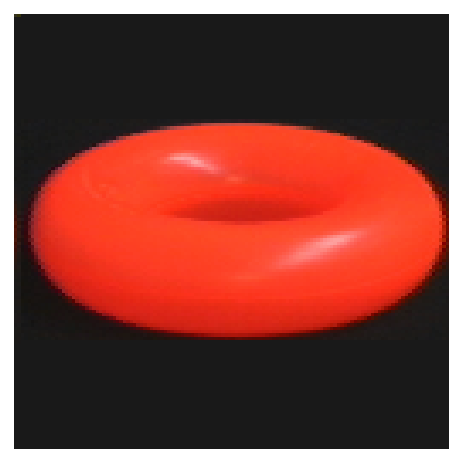

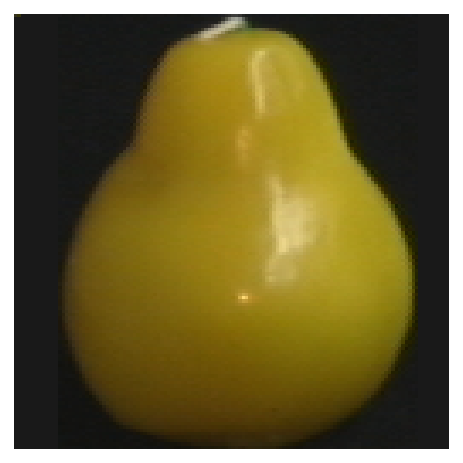

  (0, 42)	1.0
  (1, 82)	1.0


In [0]:
pic_index = 2
next_coil = [os.path.join(coil_dir, fname) for fname in coil_files[pic_index-2:pic_index]]
for i, img_path in enumerate(next_coil):
    #print(img_path)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
print(labels[pic_index-2:pic_index])   

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_i, labels, test_size=0.15, random_state=42)


# **Define the model**

Then we will define our model using conv layers that allow us to input tensor of shape (n,n,d) dimensional with instead of (n,n) dimensional arrays this will help us to input each colour layer of the image and deal with the problem of the colour variation.

*  **Convolutional Layer:** This layer tries to find patterns in the images applying filters and then will generate feature maps, this first layer is composed by 30 filters with a size of 5x5 and applies a stride of 1 also uses the relu function as the activation function.

*  **Max pooling layer:** This layer will select the most important features from the conv layer generated feature maps that use a pool size of 2 and stride equal to 1.

*  **Convolutional Layer:** This layer tries to find patterns in the images applying filters and then will generate feature maps, this first layer is composed by 15 filters with a size of 3x3 and applies a stride of 1 also uses the relu function as the activation function.

*  **Max pooling layer:** This layer will select the most important features from the conv layer generated feature maps that use a pool size of 2 and stride equal to 1.

*  **Dropout layer:** This layer is used to improve the generalization of the model, in this case, this drops 20% of the neurons from the previous layer to force the weights to be distributed equivalently.

*  **Flatten layer:** this layer flattens the input tensor to create a single long feature vector to be used by the dense layer for the final classification.

*  **Dense layer:** this layer also tries to find some relationship between the features coming from the flattening layer.

*  **Output Layer(dense):** The final layer has 100 neurons that correspond to each class, in this case, we used the softmax function to map a probability for each class.

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.python import keras

def define_model():
    # initialize the model
    model = Sequential()
    Number_of_classes = 100
    # first set of convolutional layer.
    model.add(Conv2D(30, (5, 5), input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # second set convolutional layer.
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #we will dropout 20% of the neurons to improve generalization.
    model.add(Dropout(0.2))
    # Flatten layer
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    # Output layer
    model.add(Dense(Number_of_classes, activation='softmax'))


    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [0]:
# define model
model = define_model()

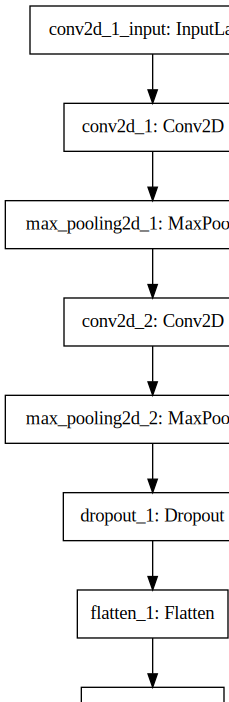

In [0]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
# fit model
train_model = model.fit(X_train, y_train,
                  batch_size=32,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 6120 samples, validate on 1080 samples
Epoch 1/20
6120/6120 [==============================] - 117s 19ms/step - loss: 4.5170 - accuracy: 0.0178 - val_loss: 3.9192 - val_accuracy: 0.0657
Epoch 2/20
6120/6120 [==============================] - 117s 19ms/step - loss: 2.6314 - accuracy: 0.3103 - val_loss: 1.7287 - val_accuracy: 0.5639
Epoch 3/20
6120/6120 [==============================] - 117s 19ms/step - loss: 1.3253 - accuracy: 0.6229 - val_loss: 0.9786 - val_accuracy: 0.7315
Epoch 4/20
6120/6120 [==============================] - 120s 20ms/step - loss: 0.7874 - accuracy: 0.7631 - val_loss: 0.6529 - val_accuracy: 0.8148
Epoch 5/20
6120/6120 [==============================] - 118s 19ms/step - loss: 0.5589 - accuracy: 0.8350 - val_loss: 0.5685 - val_accuracy: 0.8435
Epoch 6/20
6120/6120 [==============================] - 117s 19ms/step - loss: 0.4153 - accuracy: 0.8743 - val_loss: 0.4820 - val_accuracy: 0.8648
Epoch 7/20
6120/6120 [==============================] - 117s 19ms/step

# **Test prediction accuracy**
We calculate the test loss and accuracy.

In [0]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100),'loss: %f' % (loss*100))

Accuracy: 95.370370 loss: 15.334648


We have achieved 95.37% accuracy which is pretty good so far.

In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 4])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

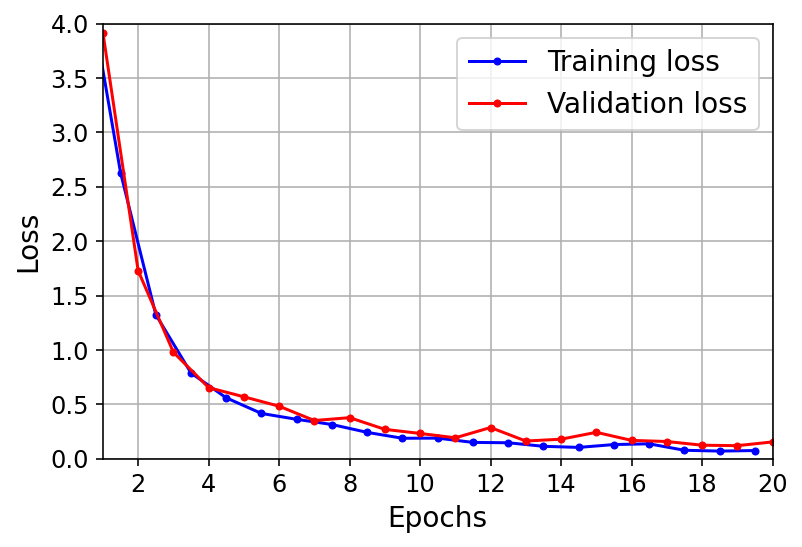

In [0]:
plot_learning_curves(train_model.history["loss"], train_model.history["val_loss"])
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
%config InlineBackend.figure_format = 'retina'
def plot_cm(y,y_predict,classes,name):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
            xticklabels=classes,
            yticklabels=classes)
    plt.title(name)
    plt.show()

In [0]:
prediction_test = model.predict(X_test)

# **Confusion Matrix**

In [0]:
prediction = encoder.inverse_transform(prediction_test)
y_real =  encoder.inverse_transform(y_test)
prediction = prediction.ravel()
y_real = y_real.ravel()

In [0]:
from sklearn.metrics import confusion_matrix
mt = confusion_matrix(y_real, prediction)
mt

array([[ 6,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 12,  0,  0],
       [ 0,  0,  0, ...,  0,  5,  0],
       [ 0,  0,  0, ...,  0,  0, 18]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

<Figure size 2160x2160 with 0 Axes>

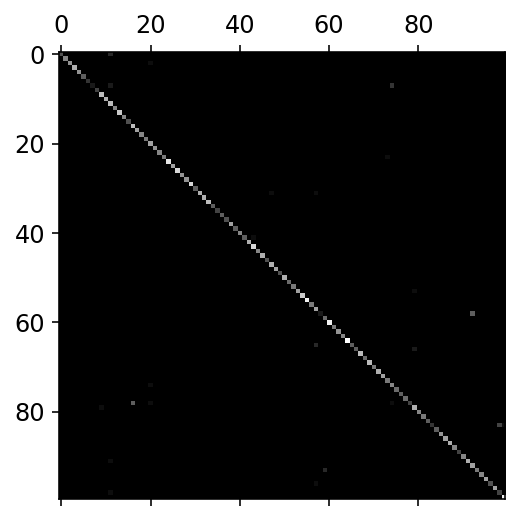

In [0]:
plt.matshow(mt, cmap=plt.cm.gray)
plt.show()

In [0]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
def plot_cm(y,y_predict,name):
    plt.figure(figsize=(13, 10))
    sns.heatmap(confusion_matrix(y,y_predict) )
    plt.title(name)
    plt.show()

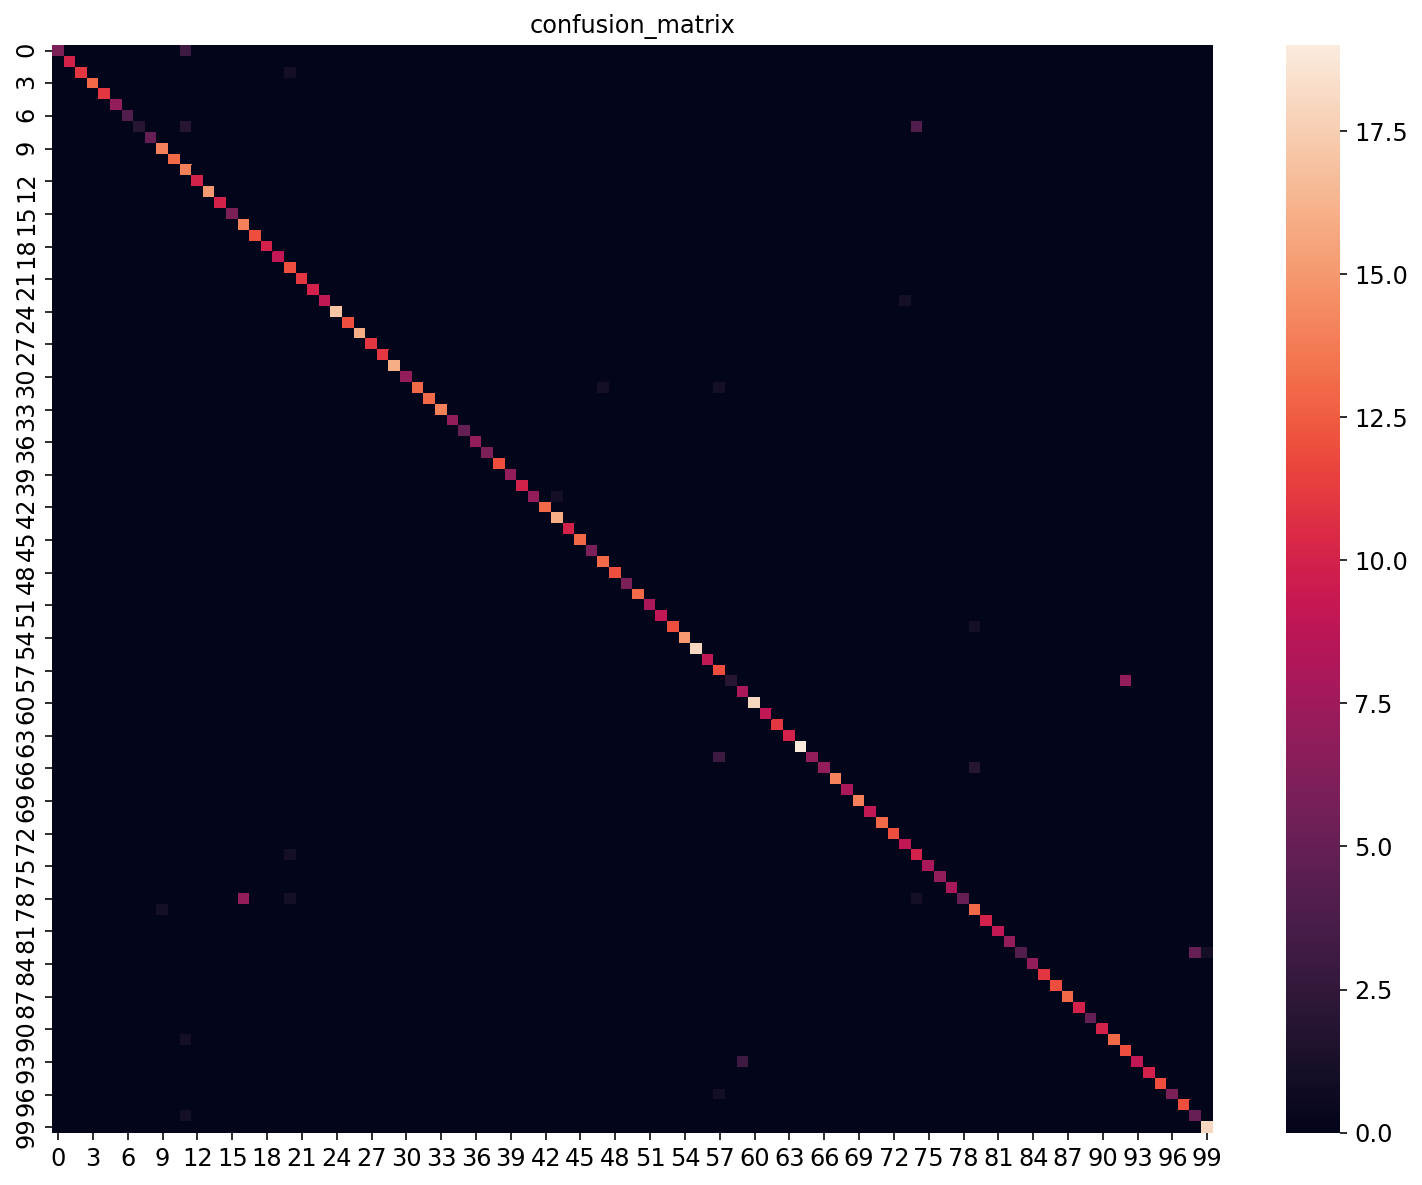

In [0]:
plot_cm(y_real, prediction,"confusion_matrix")

With the limitation of time and dataset size, data argumentation was not implemented. With this technique added and more epochs added, it is prominent to achieve higher accuracy in the future tests.

# **References:**

https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

https://www.kaggle.com/criscastromaya/cnn-for-image-classification-in-coil-100-dataset

https://www.tensorflow.org/tutorials/keras/classification

